<a href="https://colab.research.google.com/github/MixKlim/SIG-DL/blob/main/SIG_DL_2021_KM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **SIG Data & Analytics 17/02/21**
# **Deep Learning Practicum door Klim Mikhailov** 



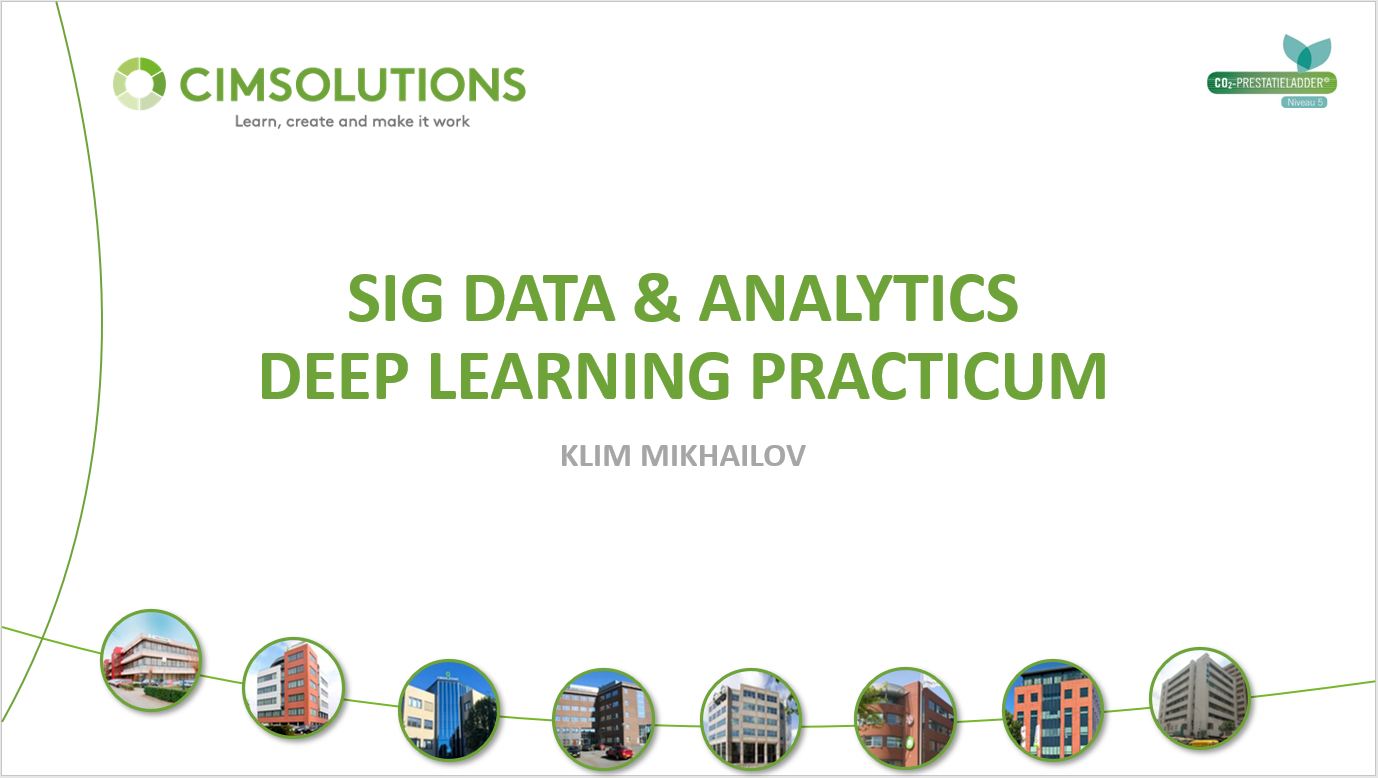

## Het verschil tussen *kunstmatige intelligentie*, *machine learning* en *deep learning*
- *Kunstmatige intelligentie of AI* is functionele intelligentie buiten het menselijk brein om. We onderscheiden sterke en beperkte AI. De sterke of brede variant richt zich op de ontwikkeling van software die zelfstandig kan redeneren en problemen op kan lossen.
- *Machine learning* houdt zich bezig met de ontwikkeling van software die de eigen performance verbetert. Machine learning leunt sterk op statistische wetenschap.
- *Deep learning* is een onderdeel van machine learning, gebaseerd op meerlaagse neurale netwerken. Er zijn talloze voorbeelden van deep learning waarbij de technologie het menselijke brein moeiteloos verslaat.

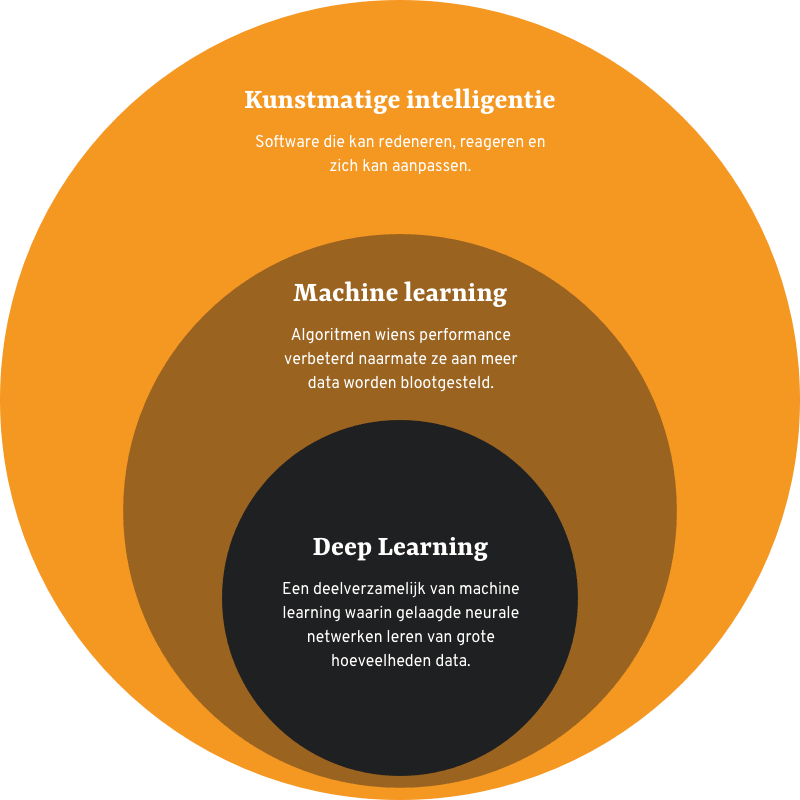

## Basis concept - Classificatie met Logistic Regression

### Kat classifier

We bouwen een eenvoudig algoritme voor beeldherkenning dat afbeeldingen correct kan classificeren als kat (1) of niet-kat (0). Beide train en test datasets bestaan uit aantal beelden, elk beeld heeft een vorm (num_px, num_px, 3) waarbij 3 voor de 3 kanalen (RGB) is.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
import imageio
from PIL import Image
from scipy import ndimage
from lr_utils import load_dataset
%matplotlib inline

In [ ]:
# default figure size
plt.rcParams['figure.figsize'] = (20, 5)

In [ ]:
# Loading the data (cat/non-cat)
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

Elke regel van de train_set_x_orig en test_set_x_orig is een array die een afbeelding vertegenwoordigt. U kunt een voorbeeld visualiseren door de volgende code uit te voeren:

y = [1], it's a 'cat' picture.


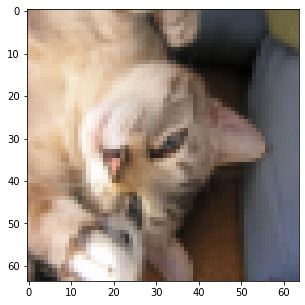

In [ ]:
# Example of a picture
index = 110
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

In [ ]:
m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig[0].shape[0]

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


Voor de eenvoud hebben we de trainings- en testgegevenssets opnieuw vormgegeven zodat afbeeldingen van grootte (num_px, num_px, 3) worden afgeplat tot enkele vormvectoren (num_px ∗ num_px ∗ 3, 1).

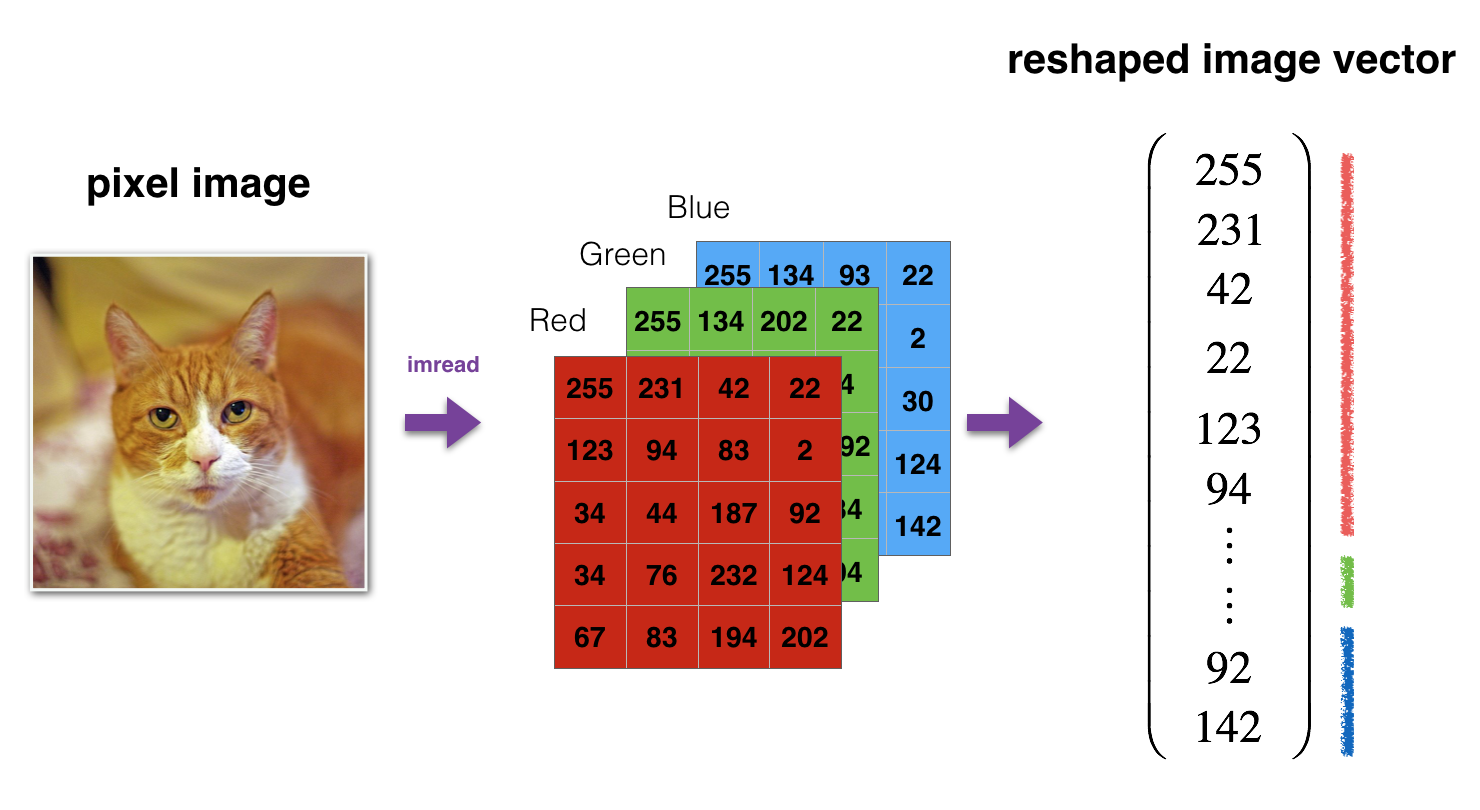

In [ ]:
# Reshape the training and test examples
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))
print ("sanity check after reshaping: " + str(train_set_x_flatten[0:5,0]))

train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)
sanity check after reshaping: [17 31 56 22 33]


Een veelvoorkomende voorverwerkingsstap bij machine learning is het centreren en standaardiseren van uw dataset, wat betekent dat u het gemiddelde van de hele numpy-array van elk voorbeeld aftrekt en vervolgens elk voorbeeld deelt door de standaarddeviatie van de hele numpy-array. Maar voor datasets met afbeeldingen is het eenvoudiger en handiger en werkt het bijna net zo goed om elke rij van de dataset te delen door 255 (de maximale waarde van een pixelkanaal).

In [ ]:
# Let's standardize our dataset.
train_set_x = train_set_x_flatten/255.
test_set_x = test_set_x_flatten/255.

### Algemene architectuur van het Logistic Regression leeralgoritme

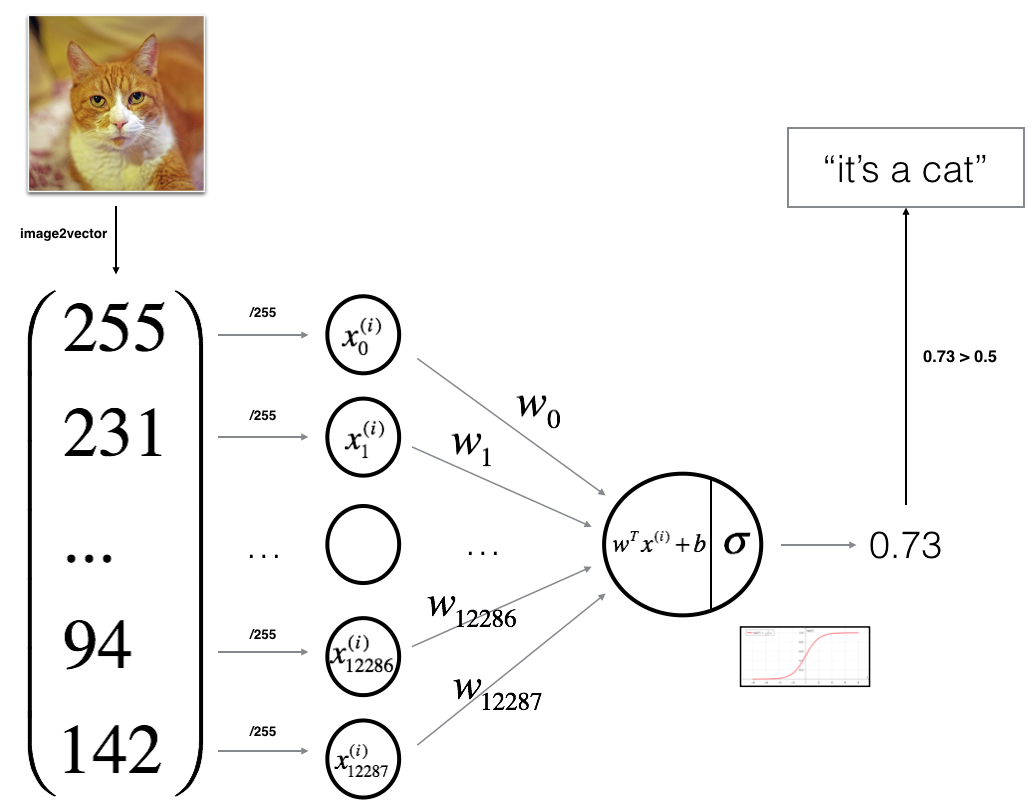

Per input $x^{(i)}$:
$$z^{(i)} = w^T x^{(i)} + b \tag{1}$$
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})\tag{2}$$ 
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}$$

De kost wordt vervolgens berekend door alle trainingsvoorbeelden bij elkaar op te tellen:
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})\tag{4}$$

### Het algoritme:
- Initialiseer de parameters van het model
- Leer de parameters voor het model door de kosten te minimaliseren
- Gebruik de aangeleerde parameters om voorspellingen te doen (op de test set)
- Analyseer de resultaten

### Sigmoid function

In [ ]:
def sigmoid(z):
    return 1. / (1 + np.exp(-z))

In [ ]:
from ipywidgets import interact
@interact(p=(0.05, 1.0, 0.05))
def f(p = 0.05):
  n = np.linspace(-100, 100, 200)
  plt.plot(n, sigmoid(p*n), color='red', label=r"$\frac{1}{1 + \exp{(-pz)}}$")
  plt.axvline(x=0.0, ls = ':')
  plt.axhline(y=0.0, ls = ':')
  plt.axhline(y=1.0, ls = ':')
  plt.legend(prop={'size': 15})
  plt.xlabel(r'$z$')
  plt.ylabel(r'$sigmoid (z)$')

interactive(children=(FloatSlider(value=0.05, description='p', max=1.0, min=0.05, step=0.05), Output()), _dom_…

### Parameter initialisatie

In [ ]:
# Parameter initialization
def initialize_with_zeros(dim):
    w = np.zeros((dim,1))
    b = 0
    return w, b

### Forward en Backward propagation

Forward Propagation:
- Je hebt input $X$
- Je berekent $A = \sigma(w^T X + b) = (a^{(1)}, a^{(2)}, ..., a^{(m-1)}, a^{(m)})$
- Vervolgens bereken je de kost: $J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)})$

Backward Propagation:
$$ \theta = \theta - \alpha \text{ } d\theta$$, waar: 
- $\alpha$ is de learning rate, 
- $\theta$ is de leerparameter ($w$, $b$), 
- $d\theta$ wordt berekent als:
$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})$$

In [ ]:
def propagate(w, b, X, Y):
    """
    The cost function and its gradient for the propagation explained above
    """
    m = X.shape[1]
    
    # FORWARD PROPAGATION (FROM X TO COST)
    A = sigmoid(np.dot(w.T,X)+b)  # compute activation
    cost = - 1./m * (np.dot(Y, np.log(A).T) + np.dot((1-Y), np.log(1-A).T)) # compute cost

    # BACKWARD PROPAGATION (TO FIND GRAD)
    dw = 1./m * np.dot(X,(A-Y).T)
    db = 1./m * np.sum(A-Y)

    cost = np.squeeze(cost)
    
    grads = {"dw": dw, "db": db}
    
    return grads, cost

In [ ]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    """
    
    costs = []
    
    for i in range(num_iterations):
        
        # Cost and gradient calculation
        grads, cost = propagate(w, b, X, Y)
        
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        # update rule
        w = w - learning_rate * dw
        b = b - learning_rate * db
        
        # Record the costs
        if i % 100 == 0:
            costs.append(cost)
        
        # Print the cost every 100 training iterations
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w, "b": b}
    
    grads = {"dw": dw, "db": db}
    
    return params, grads, costs

Nu kunnen we $w$ en $b$ gebruiken om de labels voor een dataset $X$ te voorspellen.

In [ ]:
def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    '''
    
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)
    
    # Compute vector "A" predicting the probabilities of a cat being present in the picture
    A = sigmoid(np.dot(w.T,X)+b)
    
    for i in range(A.shape[1]):
        # Convert probabilities A[0,i] to actual predictions p[0,i] as 0 (if activation <= 0.5) or 1 (if activation > 0.5)
        Y_prediction = 0. * (A <= 0.5) + 1. * (A > 0.5)
    
    return Y_prediction

### Het model

In [ ]:
def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False, print_errors = True):
    """
    Builds the logistic regression model
    """

    # initialize parameters with zeros 
    w, b = initialize_with_zeros(X_train.shape[0])

    # Gradient descent
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    
    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]
    
    # Predict test/train set examples
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)

    # Print train/test Errors
    if print_errors:
      print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
      print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

### We trainen ons model eerst ... 

In [ ]:
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.005, print_cost = True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.584508
Cost after iteration 200: 0.466949
Cost after iteration 300: 0.376007
Cost after iteration 400: 0.331463
Cost after iteration 500: 0.303273
Cost after iteration 600: 0.279880
Cost after iteration 700: 0.260042
Cost after iteration 800: 0.242941
Cost after iteration 900: 0.228004
Cost after iteration 1000: 0.214820
Cost after iteration 1100: 0.203078
Cost after iteration 1200: 0.192544
Cost after iteration 1300: 0.183033
Cost after iteration 1400: 0.174399
Cost after iteration 1500: 0.166521
Cost after iteration 1600: 0.159305
Cost after iteration 1700: 0.152667
Cost after iteration 1800: 0.146542
Cost after iteration 1900: 0.140872
train accuracy: 99.04306220095694 %
test accuracy: 70.0 %


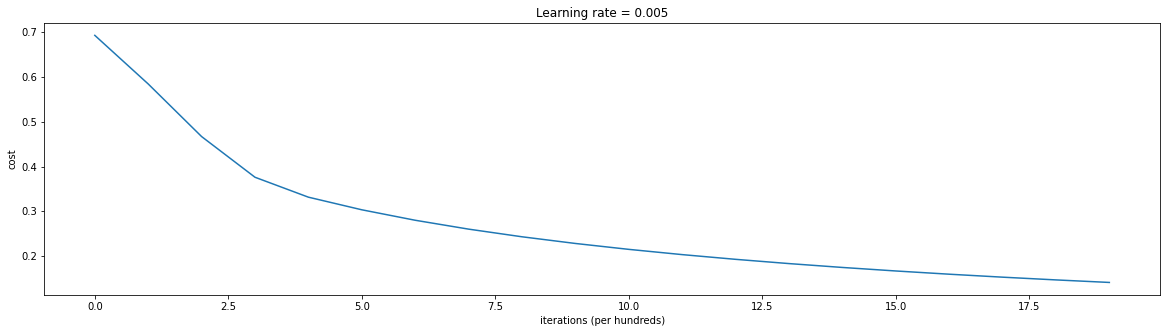

In [ ]:
# Plot learning curve (with costs)
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate = " + str(d["learning_rate"]))
plt.show()

### Verschillende learning rates

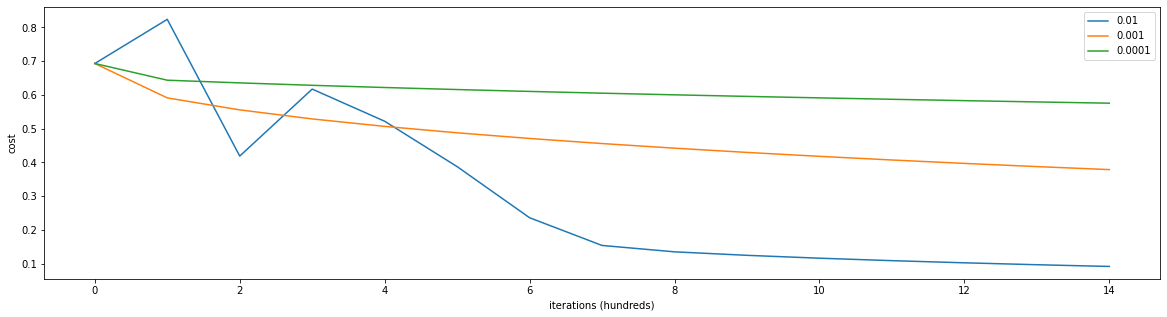

In [ ]:
learning_rates = [0.01, 0.001, 0.0001]
models = {}
for i in learning_rates:
    models[str(i)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 1500, learning_rate = i, print_cost = False, print_errors = False)
    plt.plot(np.squeeze(models[str(i)]["costs"]), label= str(models[str(i)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations (hundreds)')

plt.legend()
plt.show()

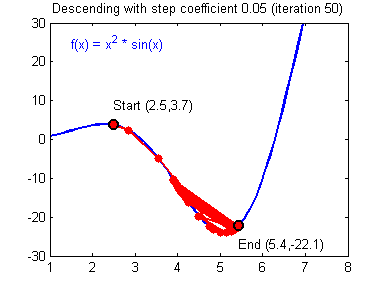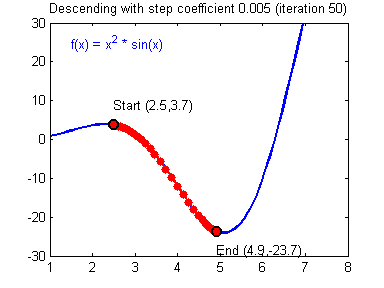

### Neurale Netwerk (1 hidden layer)

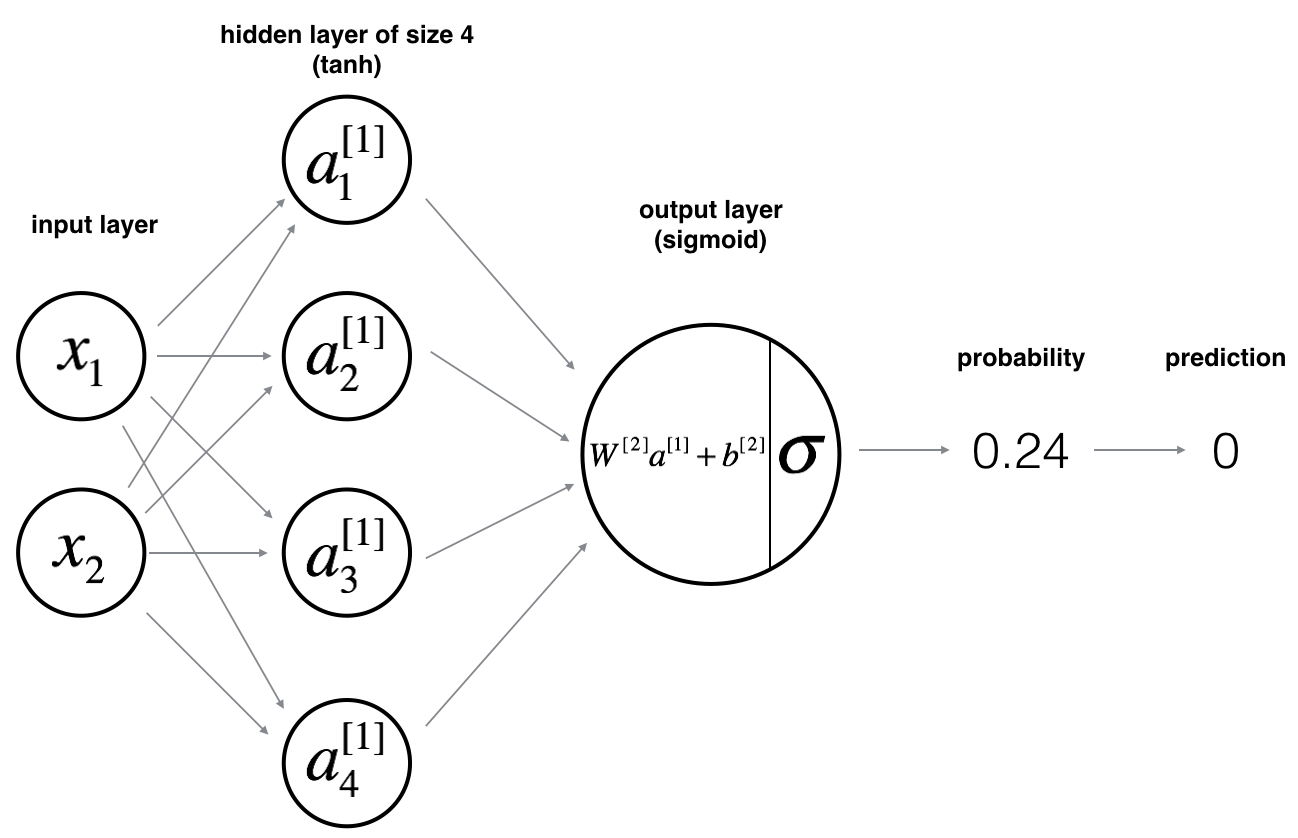

Per input $x^{(i)}$:
$$z^{[1] (i)} =  W^{[1]} x^{(i)} + b^{[1]}\tag{1}$$ 
$$a^{[1] (i)} = \tanh(z^{[1] (i)})\tag{2}$$
$$z^{[2] (i)} = W^{[2]} a^{[1] (i)} + b^{[2]}\tag{3}$$
$$\hat{y}^{(i)} = a^{[2] (i)} = \sigma(z^{ [2] (i)})\tag{4}$$
$$y^{(i)}_{prediction} = \begin{cases} 1 & \mbox{if } a^{[2](i)} > 0.5 \\ 0 & \mbox{otherwise } \end{cases}\tag{5}$$

### Activation functies

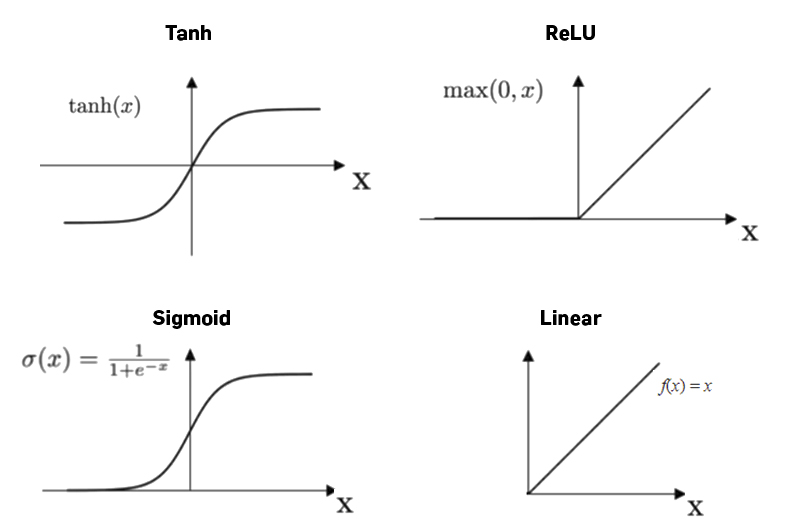

### Neurale Netwerk (L hidden layers)

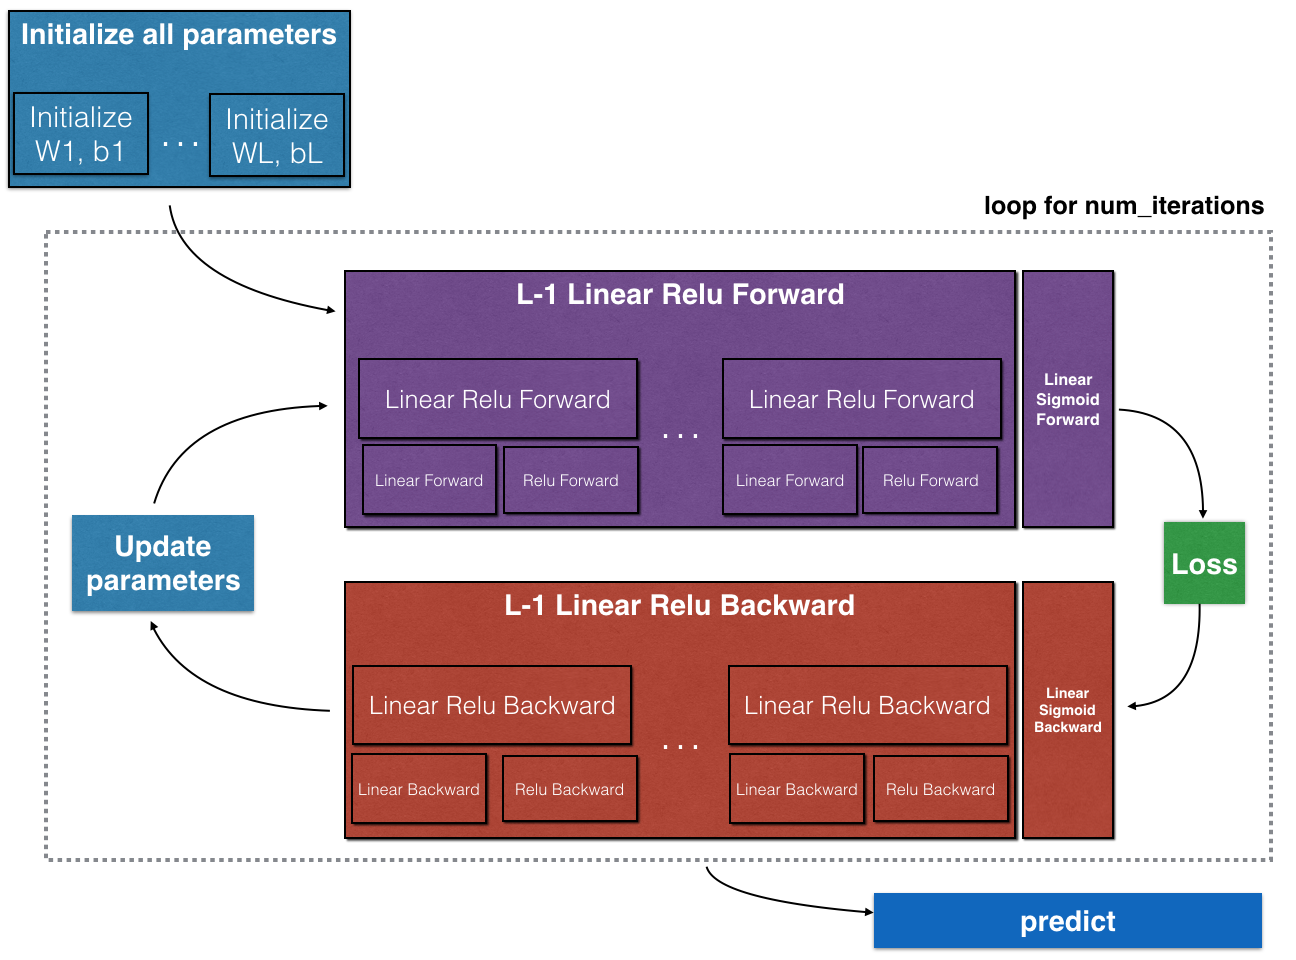

### Parameters van het netwerk initialiseren

In [ ]:
def initialize_parameters_deep(layer_dims):

    np.random.seed(3)
    parameters = {}
    L = len(layer_dims) # number of layers in the network

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * 0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
    return parameters

### Forward propagation

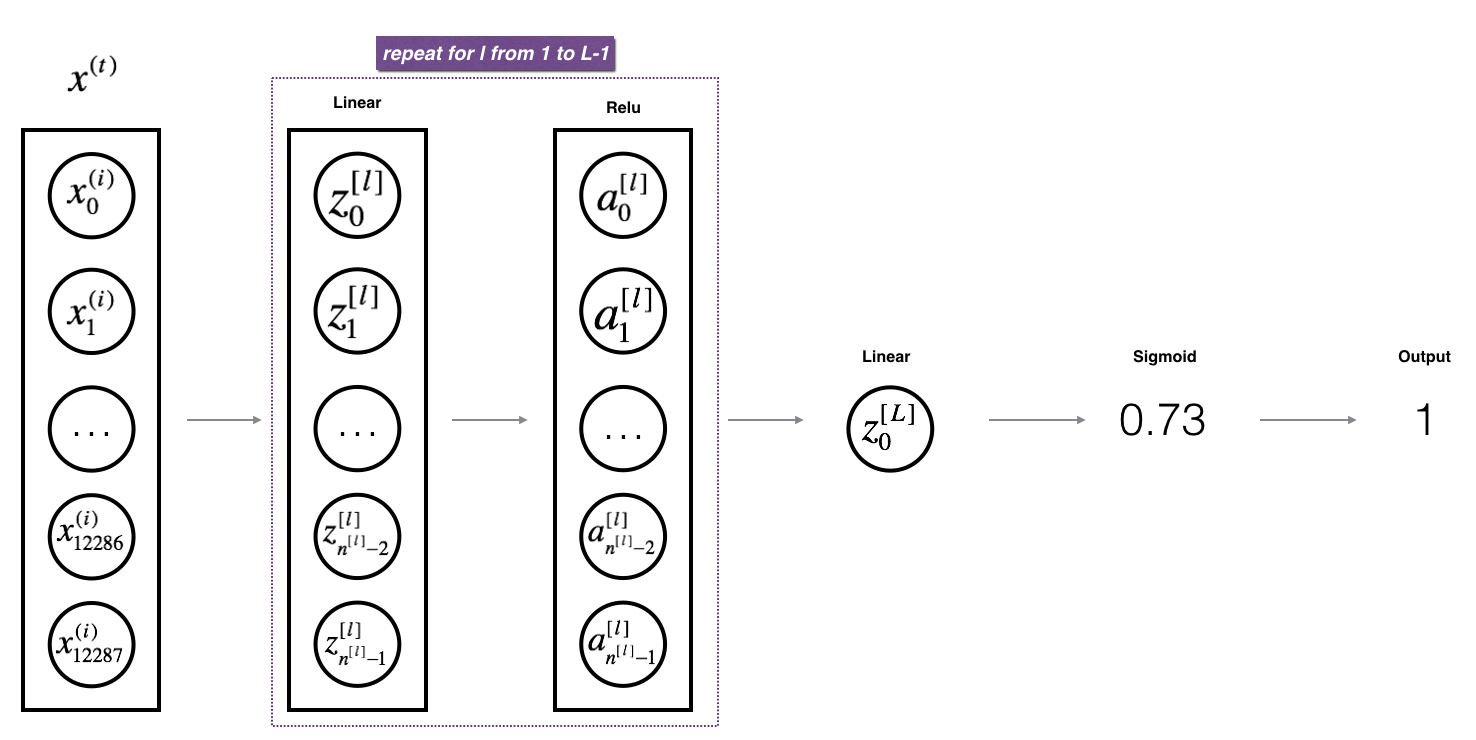

In [ ]:
def linear_activation_forward(A_prev, W, b, activation):
    """
    Implement the forward propagation for the LINEAR->ACTIVATION layer
    """
    
    if activation == "sigmoid":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    
    elif activation == "relu":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
    
    cache = (linear_cache, activation_cache)

    return A, cache

In [ ]:
def L_model_forward(X, parameters):
    """
    Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation
    """

    caches = []
    A = X
    L = len(parameters) // 2                  # number of layers in the neural network
    
    # Implement [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list.
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation = "relu")
        caches.append(cache)
    
    # Implement LINEAR -> SIGMOID. Add "cache" to the "caches" list.
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation = "sigmoid")
    caches.append(cache)
            
    return AL, caches

### Kost functie

In [ ]:
def compute_cost(AL, Y):
    """
    Implement the cost function.
    """
    
    m = Y.shape[1]

    # Compute loss from aL and y.
    cost = - 1./m * (np.dot(Y,np.log(AL).T) + np.dot((1-Y),np.log(1-AL).T))
    
    cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    
    return cost

### Backward propagation

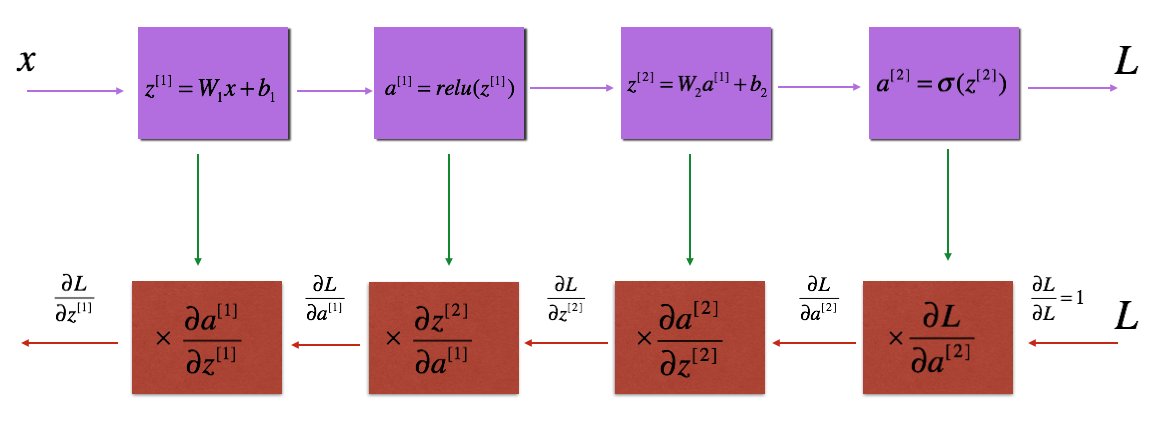

In [ ]:
def linear_activation_backward(dA, cache, activation):
    """
    Implement the backward propagation for the LINEAR->ACTIVATION layer.
    """
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)

    return dA_prev, dW, db

In [ ]:
def L_model_backward(AL, Y, caches):
    """
    Implement the backward propagation for the [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID group
    """
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    # Initializing the backpropagation
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL)) # derivative of cost with respect to AL
    
    # Lth layer (SIGMOID -> LINEAR) gradients. Inputs: "dAL, current_cache". Outputs: "grads["dAL-1"], grads["dWL"], grads["dbL"]
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation = "sigmoid")
    
    # Loop from l=L-2 to l=0
    for l in reversed(range(L-1)):
        # lth layer: (RELU -> LINEAR) gradients.
        # Inputs: "grads["dA" + str(l + 1)], current_cache". Outputs: "grads["dA" + str(l)] , grads["dW" + str(l + 1)] , grads["db" + str(l + 1)] 
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l+1)], current_cache, activation = "relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

### Terug naar ons kat classifier

### 2-layer neurale netwerk

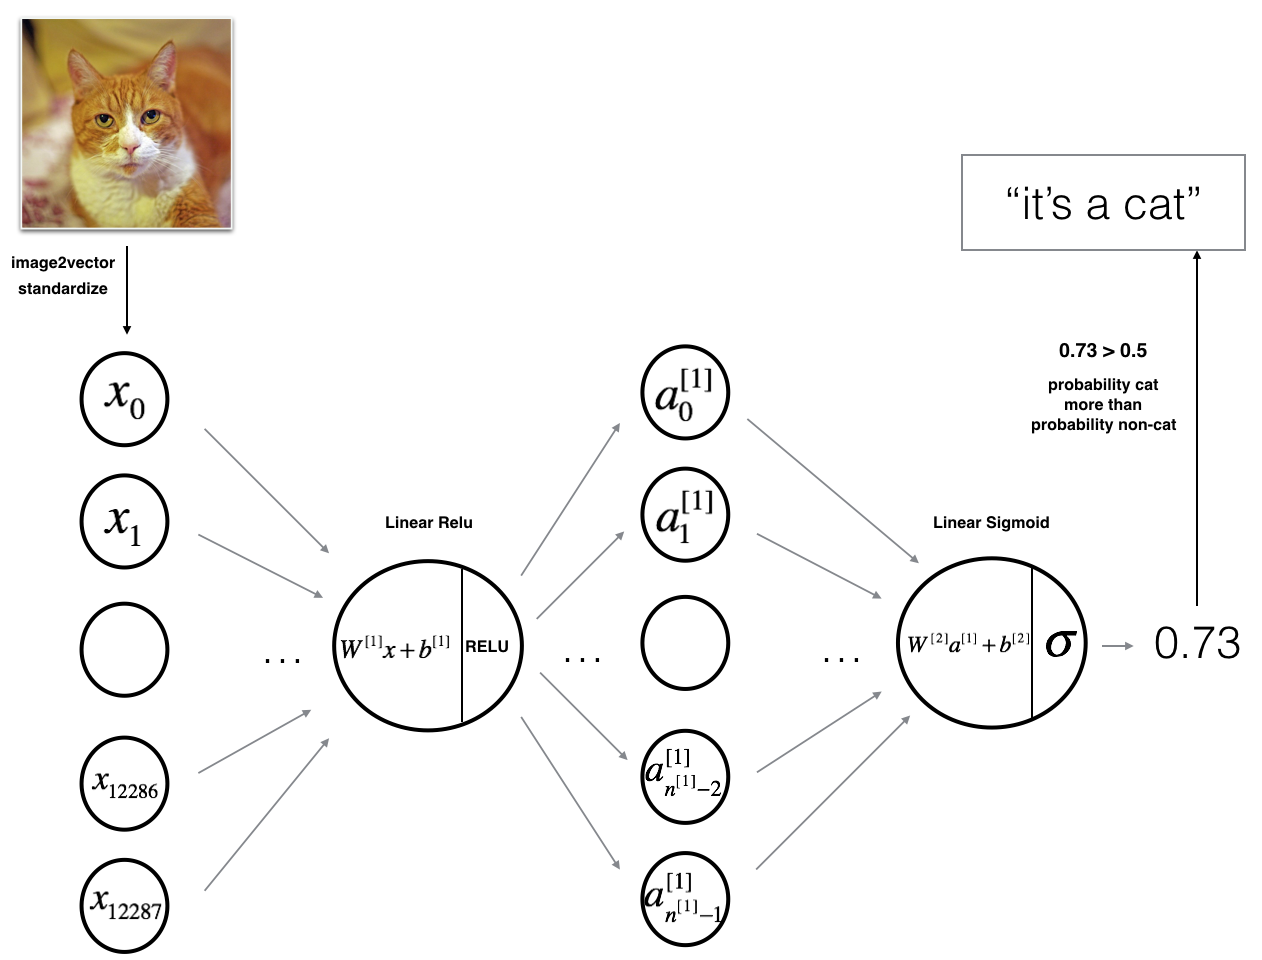

### L-layer (deep) neurale netwerk

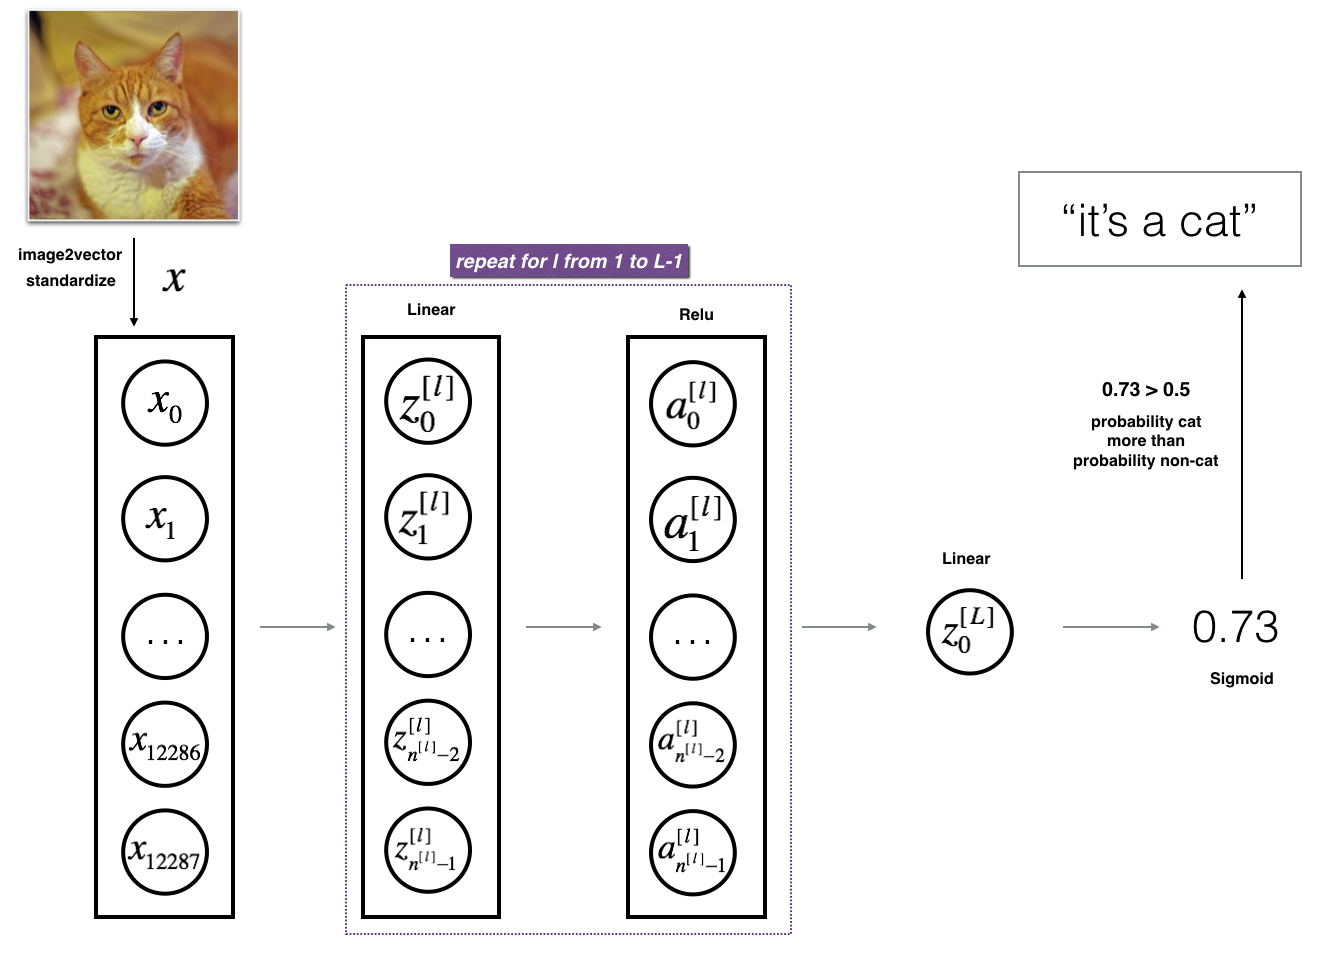

### We gaan 4 hidden layers gebruiken

In [ ]:
### CONSTANTS ###
layers_dims = [12288, 20, 7, 5, 3, 1] #  5-layer model

In [ ]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)
    costs = [] # keep track of cost
    
    # Parameters initialization.
    parameters = initialize_parameters_deep(layers_dims)
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL, caches = L_model_forward(X, parameters)
        
        # Compute cost.
        cost = compute_cost(AL, Y)
    
        # Backward propagation.
        grads = L_model_backward(AL, Y, caches)
 
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
                
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

In [ ]:
parameters = L_layer_model(train_set_x, train_set_y, layers_dims, num_iterations = 2500, print_cost = True)

NameError: ignored

**Literatuur:**
- [Andrew Ng - Deep Learning Specialization](https://www.coursera.org/specializations/deep-learning)
- [Jon Krohn - Deep Learning with TensorFlow, Keras, and PyTorch](https://github.com/jonkrohn/DLTFpT)
- [Implementing a Neural Network from Scratch in Python](http://www.wildml.com/2015/09/implementing-a-neural-network-from-scratch/)
- []()